# Biostat 257 Homework 2

**Due Apr 29 @ 11:59PM**

Ami Sheth

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i5-4260U CPU @ 1.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, haswell)


In [2]:
# load libraries
# import Pkg; Pkg.add("Images")
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

#### Solution

**Step 1: Prototyping**

In [25]:
function nnmf_prototype(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2)),
    verbose :: Bool = false # display intermediate code
    ) where T <: AbstractFloat
    # implementation
    obj = norm(X - V * W)^2 
    if verbose # useful for debugging
        println("iter = 0, obj = $obj")
    end
    niter = maxiter # if condition never met, returns max iteration
    for iter in 1:maxiter
        # update V
        V .= V .* (X * W') ./ (V * W * W')
        # update W
        W .= W .* (V' * X) ./ (V' * V * W)
        # update obj
        objold = obj
        obj = norm(X - V * W)^2 
        if verbose
            println("iter = 0, obj = $obj")
        end
        # check convergence
        if abs(obj - objold) ≤ tolfun * (abs(objold) + 1)
            niter = iter
            break
        end
    end
    if niter == maxiter
        @warn "maxiter reached without convergence"
    end
    # Output
    V, W, obj, niter
end

nnmf_prototype (generic function with 1 method)

Ways to improve allocation: 
1. BLAS function for multiplication of matrices
2. Order of multiplying matrices matters when more than 2; i.e. W by W^T first because r is low rank, so rxr is smaller
3. Look at flop counts 

What does not matter:
1. Scalars do not affect allocation
2. Elementwise operations are fused into one loop so it does not cause allocation

**Step 2: Optimize code (benchmarking, profiling, ...)**

In [81]:
function nnmf(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2)),
    verbose :: Bool = false
    ) where T <: AbstractFloat
    # implementation
    if verbose
        println("iter = 0, obj = $obj")
    end
    niter = maxiter  
    # preallocation for matrix multiplication 
    storageR = Matrix{T}(undef, r, r) # store V'V and WW' since both rxr
    storageV1 = similar(V) # same dimension as V
    storageV2 = similar(V)
    storageW1 = similar(W) # same dimension as W
    storageW2 = similar(W)
    x2norm = norm(X)^2
    # initial objective
    obj = x2norm
    # matrix multiplication needed for Frobenius norm
    # better to write function here
    mul!(storageR, transpose(V), V) # stores V'V (rxr)
    mul!(storageW2, storageR, W) # stores V'VW (rxn)
    mul!(storageW1, transpose(V), X) # stores V'X (rxn)
    @inbounds for idx in eachindex(W)
        obj = obj + (storageW2[idx] - 2storageW1[idx]) * W[idx]
    end
    for iter in 1:maxiter
        # update V .= V .* (X * W') ./ (V * (W * W'))
        mul!(storageR, W, transpose(W)) # stores WW' (rxr)
        mul!(storageV2, V, storageR) # stores VWW' (mxr)
        mul!(storageV1, X, transpose(W)) # store XW'(mxr)
        V .= V .* storageV1 ./ storageV2
        # update W .= W .* (V' * X) ./ ((V' * V) * W)
        mul!(storageR, transpose(V), V) # stores V'V (rxr)
        mul!(storageW2, storageR, W) # stores V'VW (rxn)
        mul!(storageW1, transpose(V), X) # stores V'X (rxn)
        objold = obj
        # update obj
        obj = x2norm
        @inbounds for idx in eachindex(W)
            obj = obj + (storageW2[idx] - 2storageW1[idx]) * W[idx]
            W[idx] = W[idx] * storageW1[idx] / storageW2[idx]
        end
        if verbose
            println("iter = 0, obj = $obj")
        end
        # check convergence
        if abs(obj - objold) ≤ tolfun * (abs(objold) + 1)
            niter = iter
            break
        end
    end
    if niter == maxiter
        @warn "maxiter reached without convergence"
    end
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

#### Solution

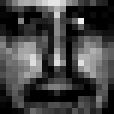

In [189]:
X = readdlm("nnmf-2429-by-361-face.txt") 
colorview(Gray, reshape(X[1, :], 19, 19)) # each row is a face
# goal: obtain a low rank approximation of the original faces

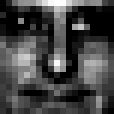

In [15]:
colorview(Gray, reshape(X[5, :], 19, 19))

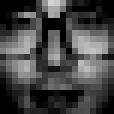

In [190]:
colorview(Gray, reshape(X[50, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  1.047598 seconds (20 allocations: 6.904 MiB)
obj=11730.38800985483, niter=239
r=20
  1.913147 seconds (20 allocations: 7.120 MiB)
obj=8497.222317850326, niter=394
r=30
  2.434662 seconds (20 allocations: 7.336 MiB)
obj=6621.627345486279, niter=482
r=40
  3.424469 seconds (22 allocations: 7.554 MiB)
obj=5256.663870563529, niter=581
r=50
  4.480342 seconds (23 allocations: 7.774 MiB)
obj=4430.201581697291, niter=698
```
Since my laptop is about 6-7 years old, I expect to see your run time shorter than mine. Your memory allocation should be less or equal to mine.

#### Solution 

In [164]:
V0full = readdlm("V0.txt")
W0full = readdlm("W0.txt")

50×361 Matrix{Float64}:
 0.5634    0.32048   0.067202   0.25107   …  0.4476     0.12656   0.13688
 0.71473   0.25423   0.084735   0.84327      0.20947    0.32729   0.43787
 0.046351  0.041688  0.79152    0.8962       0.6786     0.17112   0.83691
 0.76991   0.13366   0.0061026  0.70588      0.4457     0.012722  0.64244
 0.56335   0.35408   0.62697    0.94923      0.073816   0.62934   0.58596
 0.13659   0.82449   0.17183    0.051802  …  0.87725    0.86247   0.45418
 0.2326    0.92296   0.73855    0.35246      0.015108   0.68424   0.15457
 0.95628   0.97221   0.94922    0.59106      0.49038    0.52232   0.4399
 0.82876   0.33257   0.95808    0.11028      0.66812    0.69979   0.57679
 0.33585   0.59454   0.75948    0.26544      0.34689    0.071471  0.020196
 0.87571   0.83349   0.83207    0.57283   …  0.34609    0.22545   0.2295
 0.27631   0.10171   0.4809     0.10614      0.0039955  0.92647   0.27393
 0.914     0.45783   0.32193    0.65607      0.1204     0.29447   0.88988
 ⋮             

In [192]:
r = 10
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
nnmf(X, r; V = V0, W = W0)

([0.1185155250605055 0.02994050345509698 … 0.0028830808553836434 0.06420991048712604; 0.13176807592569617 0.0004309168162359832 … 0.014863431363093798 0.03502874558367169; … ; 0.05270583755824644 0.04794098005163979 … 0.1700196278798266 0.04626182097825304; 0.12933014679416052 0.019567810402128034 … 0.09435983264067124 0.029580777291877254], [3.385885235846814e-27 1.174537573868145e-27 … 0.2300193333797503 2.2801686250907805e-6; 0.010899790573386688 1.7007366080211221e-6 … 9.165787020780837e-15 5.134415347265115e-11; … ; 4.0722852963974885e-10 0.0001197464191754901 … 6.6113838164410616e-6 1.37989840473972e-12; 5.698509363463882e-10 6.980500700786509e-9 … 2.2318529440908972e-14 1.8764490698063353e-18], 11730.866905749992, 239)

In [193]:
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
@time nnmf(X, r; V = V0, W = W0)

  1.079522 seconds (12 allocations: 437.297 KiB)


([0.1185155250605055 0.02994050345509698 … 0.0028830808553836434 0.06420991048712604; 0.13176807592569617 0.0004309168162359832 … 0.014863431363093798 0.03502874558367169; … ; 0.05270583755824644 0.04794098005163979 … 0.1700196278798266 0.04626182097825304; 0.12933014679416052 0.019567810402128034 … 0.09435983264067124 0.029580777291877254], [3.385885235846814e-27 1.174537573868145e-27 … 0.2300193333797503 2.2801686250907805e-6; 0.010899790573386688 1.7007366080211221e-6 … 9.165787020780837e-15 5.134415347265115e-11; … ; 4.0722852963974885e-10 0.0001197464191754901 … 6.6113838164410616e-6 1.37989840473972e-12; 5.698509363463882e-10 6.980500700786509e-9 … 2.2318529440908972e-14 1.8764490698063353e-18], 11730.866905749992, 239)

In [191]:
for r in [10]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end

r=10
  1.561017 seconds (22 allocations: 437.641 KiB)
obj=11730.866905749992, niter=239


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

#### Solution

In [171]:
r = 10
V1 = V0full[:, 2:(r + 1)]
W1 = W0full[2: (r + 1), :]
nnmf(X, r; V = V1, W = W1)

([0.058981075055638224 0.14525209007122994 … 0.019055146210778362 0.07053298554909462; 0.004489426466693886 0.14816955761610148 … 0.0041909068195955705 0.04073934701123995; … ; 0.02112368252898036 0.003989718130885983 … 0.0018885614698087038 0.06539979614759503; 4.938926389647611e-5 0.12717549471004394 … 0.006553939033269752 0.026018142255132704], [0.08343350414395032 2.023563251255995e-7 … 1.6735275142115434e-16 4.008843253562877e-15; 1.9863288485978493e-15 4.545304585858992e-22 … 0.27820918282473767 0.23423504689982172; … ; 0.3526749465524293 0.5997881823823353 … 4.572575155398515e-18 4.040115662527214e-22; 5.553454536254431e-17 1.742428240709883e-16 … 3.4088360310866805e-5 3.7558878994914313e-13], 11766.631378380396, 212)

No, I do not obtain the same objective value and ($\textbf{V}, \textbf{W}$). The objective value, ($\textbf{V}, \textbf{W}$) depends on which iteration the stopping criterion is met. Convergence and objective value are around the same as the above example.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

In [175]:
r = 10
m, n = size(X)
V2 = ones(m, r)
W2 = ones(r, n)
nnmf(X, r; V = V2, W = W2)

([0.02737339344273954 0.02737339344273954 … 0.02737339344273954 0.02737339344273954; 0.027206938610572086 0.027206938610572086 … 0.027206938610572086 0.027206938610572086; … ; 0.02852019540472512 0.02852019540472512 … 0.02852019540472512 0.02852019540472512; 0.028030925515084775 0.028030925515084775 … 0.028030925515084775 0.028030925515084775], [0.36995177994768613 0.46065860110694046 … 0.558079395200944 0.4255210382434648; 0.36995177994768613 0.46065860110694046 … 0.558079395200944 0.4255210382434648; … ; 0.36995177994768613 0.46065860110694046 … 0.558079395200944 0.4255210382434646; 0.36995177994768613 0.46065860110694046 … 0.558079395200944 0.4255210382434646], 25297.015778490062, 4)

No, I do not obtain the same objective value and ($\textbf{V}, \textbf{W}$). The objective value is about the same as previous examples for the same r, but the number of iterations is only 4. Convergence appears to be faster.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

In [181]:
r = 50
V0 = V0full[:, 1:r]
W0 = W0full[1:r, :]
V, W, obj, niter = nnmf(X, r; V = V0, W = W0)

([4.065152683367589e-8 0.02391830987010448 … 0.0050275293945103005 0.030895205383236247; 2.066922665650733e-5 0.01676918953044336 … 0.0016843647387214 0.03357388284868296; … ; 0.013653571084018568 0.020407618225550362 … 8.933004101207235e-5 0.04512260292309185; 0.01821569164993885 0.009941879525504831 … 5.393742344944298e-6 0.00014298874864300805], [1.988389142207648e-64 1.2476690072002253e-53 … 2.7319238780356062e-14 8.879923560802795e-65; 5.008532883861646e-27 2.3803648259630052e-26 … 2.005876391414098e-32 4.4803366072845716e-61; … ; 3.6009667110863195e-15 2.707734064744678e-15 … 3.862314406203127e-22 2.4110065875282863e-44; 0.00024987101520910555 6.687159725272475e-20 … 2.362593695158234e-7 1.3046824185960588e-11], 4430.36209731353, 698)

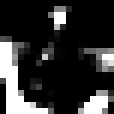

In [187]:
colorview(Gray, reshape(W[5, :], 19, 19))

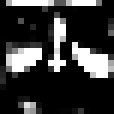

In [186]:
colorview(Gray, reshape(W[50, :], 19, 19))

The rows of W are low-rank approximation of the faces from the rows of X. Compared to X, when r = 50, the images are still blurry.

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

## Q2. Estimating Kinship Matrix

Consider the numerical task of estimating an $n \times n$ kinship matrix $\Phi$ from an $n \times m$ genotype matrix $\mathbf{G}$. Here $n$ is the number of individuals and $m$ is the number of genetic markers. [Lange et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6763373/) derived a method of moment estimator of form
$$
    \widehat \Phi_{ij} = \frac{e_{ij} - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}{m - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}, \quad 1 \le i, j \le n,
$$
where
$$
\begin{eqnarray*}
    e_{ij} &=& \frac{1}{4} \sum_{k=1}^m [g_{ik} g_{jk} + (2 - g_{ik})(2 - g_{jk})] \\
    p_k &=& \frac {1}{2n} \sum_{i=1}^n g_{ik}.
\end{eqnarray*}
$$

### Q2.1 Develop code

Write a function that takes a matrix `G` as input and outputs the method of moment estimator. 
Make your function as efficient (both speed and memory) as possible.    

In [211]:
function kinship(G::Matrix{T}) where T <: AbstractFloat
    n, m = size(G)
    # TODO: your code here
    # pre-allocate
    Φ = zeros(n, n)
    E = Matrix{T}(undef, n, n) 
    vec_scaled = ones(n) ./ (2 .* n)
    P = zeros(m)
    Psub1 = zeros(m)
    #G2 = similar(G)
    #G2 .= 2 .- G
    #@inbounds for idx in eachindex(G)
    #    G2[idx] = 2 - G[idx]
    #end
    storageG = similar(E)
    storageG2 = similar(E)
    # assign value
    mul!(P, transpose(G), vec_scaled)
    Psub1 .= (1 .- P) 
    c = dot(P, P) + dot(Psub1, Psub1) # constant
    mul!(storageG, G, transpose(G))
    #overwrite G
    # G .= 2 .- G 
    @inbounds for idx in eachindex(G)
        G[idx] = 2 - G[idx]
    end
    mul!(storageG2, G, transpose(G))
    E .= (storageG .+ storageG2) ./ 4
    # output
    Φ .= (E .- c) ./ (m - c)
end

kinship (generic function with 1 method)

In [195]:
Random.seed!(257)
G = rand(0.0:2.0, 1000, 10000)

1000×10000 Matrix{Float64}:
 1.0  0.0  2.0  0.0  0.0  2.0  2.0  2.0  …  2.0  0.0  0.0  2.0  2.0  2.0  1.0
 2.0  2.0  1.0  2.0  0.0  0.0  1.0  0.0     2.0  2.0  0.0  1.0  2.0  2.0  1.0
 1.0  0.0  2.0  1.0  1.0  1.0  2.0  0.0     0.0  1.0  1.0  0.0  1.0  2.0  0.0
 2.0  0.0  1.0  0.0  0.0  1.0  1.0  2.0     1.0  1.0  0.0  2.0  0.0  2.0  1.0
 1.0  2.0  1.0  2.0  2.0  1.0  0.0  0.0     1.0  1.0  1.0  2.0  1.0  1.0  0.0
 1.0  0.0  1.0  2.0  0.0  1.0  1.0  1.0  …  2.0  0.0  0.0  2.0  0.0  1.0  2.0
 2.0  2.0  1.0  1.0  0.0  1.0  1.0  1.0     1.0  1.0  1.0  2.0  1.0  0.0  2.0
 2.0  2.0  1.0  1.0  1.0  1.0  2.0  1.0     2.0  1.0  2.0  2.0  0.0  0.0  1.0
 2.0  1.0  1.0  2.0  0.0  0.0  2.0  2.0     0.0  0.0  1.0  0.0  2.0  2.0  0.0
 0.0  1.0  2.0  0.0  0.0  2.0  1.0  1.0     2.0  1.0  0.0  0.0  0.0  2.0  1.0
 2.0  2.0  1.0  1.0  1.0  2.0  1.0  0.0  …  1.0  1.0  2.0  0.0  1.0  1.0  2.0
 2.0  1.0  0.0  0.0  2.0  0.0  1.0  2.0     0.0  0.0  2.0  1.0  2.0  1.0  2.0
 1.0  2.0  2.0  2.0  0.0  1.0  2.0  

In [105]:
P = (G'l)/(2*n)
c = dot(P, P) + dot(Psub1, Psub1)

10000-element Vector{Float64}:
 0.4905
 0.5025
 0.495
 0.5095
 0.4795
 0.497
 0.502
 0.4935
 0.4875
 0.492
 0.4965
 0.509
 0.481
 ⋮
 0.488
 0.4835
 0.4945
 0.4985
 0.496
 0.487
 0.507
 0.5025
 0.497
 0.51
 0.5
 0.4765

In [122]:
m = size(G, 2)
n = size(G, 1)
P = zeros(m)
l = ones(n) ./ (2 .* n)
@benchmark mul!($P, transpose($G), $l)

BenchmarkTools.Trial: 811 samples with 1 evaluation.
 Range (min … max):  4.944 ms …  14.658 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.922 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.130 ms ± 712.609 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

            ▃▇█▄▁▁▂                                            
  ▂▁▂▂▂▂▂▃▄▇███████▆▇▅▅▆▆█▆▆▆▄▄▅▅▆▅▅▅▄▄▃▃▃▃▄▂▂▃▂▃▂▂▂▃▁▂▁▂▁▂▁▂ ▄
  4.94 ms         Histogram: frequency by time        8.24 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [142]:
storageG = zeros(n, n)
storageG2 = zeros(n, n)
mul!(storageG, G, transpose(G))
mul!(storageG2, (2 .- G), transpose(2 .- G))

1000×1000 Matrix{Float64}:
 16726.0  10009.0   9857.0  10130.0  …  10197.0  10007.0  10137.0   9793.0
 10009.0  16686.0   9804.0  10007.0     10136.0  10021.0  10150.0   9846.0
  9857.0   9804.0  16419.0  10087.0      9965.0   9839.0   9760.0   9691.0
 10130.0  10007.0  10087.0  16869.0     10224.0  10160.0  10236.0   9990.0
 10100.0  10115.0   9985.0  10088.0     10226.0  10233.0  10054.0   9930.0
  9894.0   9876.0   9718.0  10022.0  …   9981.0   9771.0  10034.0   9809.0
 10018.0   9920.0   9877.0  10033.0     10041.0  10020.0   9935.0   9853.0
 10041.0  10075.0   9808.0  10153.0     10097.0  10003.0  10011.0   9774.0
 10062.0  10105.0  10078.0  10245.0     10133.0  10020.0  10081.0   9873.0
  9989.0   9918.0   9930.0   9985.0      9989.0   9873.0   9893.0   9930.0
  9847.0   9751.0   9699.0   9829.0  …   9779.0   9728.0   9851.0   9559.0
  9920.0   9889.0   9840.0  10106.0     10031.0   9830.0  10005.0   9706.0
 10151.0  10196.0  10003.0  10352.0     10274.0  10115.0  10129.0   9972.

In [91]:
Psub1 = zeros(m)
#Psub1 .= (1 .- P)
@benchmark $Psub1 .= (1 .- $P)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  4.219 μs …  27.462 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.254 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.416 μs ± 742.743 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▆▂        ▁    ▂                                       ▁   ▁
  █████▇▆▇▇▆▆█▆▅▅▇█▇▅▄▅▇▄▁▅▄█▅▃▁▁▄▇▇▁▁▄▅▄▅▄▁▅▄▄▃▃▃▄▃▄▃▄▄▄▄█▇▅ █
  4.22 μs      Histogram: log(frequency) by time      7.42 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [94]:
E = zeros(n, n)
#@benchmark $E .= ($G * $G' + (2 .- $G) * (2 .- $G)')/4
E .= (G * G' + (2 .- G) * (2 .- G)')/4

1000×1000 Matrix{Float64}:
 8369.0  4999.5  4990.0  5020.5  5018.0  …  5071.0  5008.0  5057.5  4981.0
 4999.5  8327.0  4952.5  4948.0  5014.5     5029.5  5004.0  5053.0  4996.5
 4990.0  4952.5  8326.5  5054.5  5016.0     5010.5  4979.5  4924.5  4985.5
 5020.5  4948.0  5054.5  8339.5  4961.5     5034.0  5034.0  5056.5  5029.0
 5018.0  5014.5  5016.0  4961.5  8320.0     5047.5  5083.0  4978.0  5011.5
 4992.0  4972.0  4959.5  5005.5  5001.0  …  5002.0  4929.0  5045.0  5028.0
 5037.5  4977.5  5022.5  4994.5  5046.5     5015.5  5037.0  4979.0  5033.5
 5023.5  5029.5  4962.5  5029.0  5005.5     5018.0  5003.0  4991.5  4968.5
 5004.5  5015.0  5068.0  5045.5  4983.5     5006.5  4982.0  4997.0  4988.5
 5031.5  4985.0  5057.5  4979.0  4956.5     4998.0  4972.0  4966.5  5080.5
 5032.0  4973.0  5013.5  4972.5  4981.0  …  4964.5  4971.0  5017.0  4966.5
 4987.0  4960.5  5002.5  5029.5  5036.0     5009.0  4940.5  5012.5  4958.5
 5006.5  5018.0  4988.0  5056.5  4960.5     5034.5  4987.0  4978.5  4995.

In [100]:
@benchmark mul!($W, 2 .- $G, transpose(2 .- $G))

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  383.171 ms … 647.523 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     473.428 ms               ┊ GC (median):    2.82%
 Time  (mean ± σ):   472.450 ms ±  71.196 ms  ┊ GC (mean ± σ):  2.76% ± 2.90%

  ▁  ▁     ▁     █    ▁ █▁         ▁                          ▁  
  █▁▁█▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁█▁██▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  383 ms           Histogram: frequency by time          648 ms <

 Memory estimate: 152.59 MiB, allocs estimate: 4.

In [106]:
mul!(W, 2 .- G, transpose(2 .- G))

1000×1000 Matrix{Float64}:
 16726.0  10009.0   9857.0  10130.0  …  10197.0  10007.0  10137.0   9793.0
 10009.0  16686.0   9804.0  10007.0     10136.0  10021.0  10150.0   9846.0
  9857.0   9804.0  16419.0  10087.0      9965.0   9839.0   9760.0   9691.0
 10130.0  10007.0  10087.0  16869.0     10224.0  10160.0  10236.0   9990.0
 10100.0  10115.0   9985.0  10088.0     10226.0  10233.0  10054.0   9930.0
  9894.0   9876.0   9718.0  10022.0  …   9981.0   9771.0  10034.0   9809.0
 10018.0   9920.0   9877.0  10033.0     10041.0  10020.0   9935.0   9853.0
 10041.0  10075.0   9808.0  10153.0     10097.0  10003.0  10011.0   9774.0
 10062.0  10105.0  10078.0  10245.0     10133.0  10020.0  10081.0   9873.0
  9989.0   9918.0   9930.0   9985.0      9989.0   9873.0   9893.0   9930.0
  9847.0   9751.0   9699.0   9829.0  …   9779.0   9728.0   9851.0   9559.0
  9920.0   9889.0   9840.0  10106.0     10031.0   9830.0  10005.0   9706.0
 10151.0  10196.0  10003.0  10352.0     10274.0  10115.0  10129.0   9972.

In [101]:
@benchmark $E .= ($T + $W)/4

BenchmarkTools.Trial: 402 samples with 1 evaluation.
 Range (min … max):   5.545 ms … 63.696 ms  ┊ GC (min … max):  0.00% … 75.61%
 Time  (median):     11.495 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   12.521 ms ±  9.793 ms  ┊ GC (mean ± σ):  17.20% ± 17.93%

  █▆ ▃ ▁   ▅▆▂▂▃                                               
  ████▁█▇▆▅███████▅▁▄▅▄▄▁▁▄▄▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆▄▆▆▅▅▄▁▁▅▅▅ ▇
  5.55 ms      Histogram: log(frequency) by time      48.7 ms <

 Memory estimate: 15.26 MiB, allocs estimate: 4.

### Q2.2 Correctness

First let's make sure our function yields correct answer. Run your function on a fake genotype matrix

In [212]:
# generate a fake genotype matrix with entries {0, 1, 2}
Random.seed!(257)
G = rand(0.0:2.0, 1000, 10000)
Φ = kinship(G)

1000×1000 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   …   0.0108448    -0.00446532
 -0.000762864   0.665178     -0.0101691        0.00994423   -0.00136326
 -0.00266412   -0.0101691     0.665078        -0.0157728    -0.00356472
  0.00343992   -0.0110697     0.0102444        0.0106447     0.00514105
  0.00293959    0.00223912    0.00253932      -0.00506571    0.00163873
 -0.00226386   -0.00626651   -0.00876817   …   0.00834317    0.00494091
  0.00684217   -0.00516578    0.00384018      -0.00486558    0.00604164
  0.00404032    0.00524111   -0.00816777      -0.00236392   -0.00696697
  0.000237799   0.00233919    0.0129462       -0.0012632    -0.00296432
  0.00564138   -0.00366479    0.0108448       -0.00736724    0.0154479
  0.00574144   -0.00606638    0.00203899   …   0.00273946   -0.00736724
 -0.00326452   -0.00856803   -0.000162467      0.00183886   -0.0089683
  0.000638064   0.00293959   -0.00306439      -0.00496565   -0.00156339
  ⋮                                    

Compare the upper left $5 \times 5$ block to what I got using my implementation

```julia
Φ[1:5, 1:5]
```

```
5×5 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   0.00343992   0.00293959
 -0.000762864   0.665178     -0.0101691   -0.0110697    0.00223912
 -0.00266412   -0.0101691     0.665078     0.0102444    0.00253932
  0.00343992   -0.0110697     0.0102444    0.66768     -0.0083679
  0.00293959    0.00223912    0.00253932  -0.0083679    0.663777
```

In [204]:
Φ[1:5, 1:5]

5×5 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   0.00343992   0.00293959
 -0.000762864   0.665178     -0.0101691   -0.0110697    0.00223912
 -0.00266412   -0.0101691     0.665078     0.0102444    0.00253932
  0.00343992   -0.0110697     0.0102444    0.66768     -0.0083679
  0.00293959    0.00223912    0.00253932  -0.0083679    0.663777

### Q2.3 Efficiency

In a typical genetic data set, $n$ is at order of $10^3 \sim 10^6$ and $m$ is at order of $10^6 \sim 10^7$. Benchmark your function using the smaller data set $G$ generated in Q2.2. Efficiency (both speed and memory) will be the most important criterion when grading this question.

In [213]:
# benchmark
@btime kinship($G)

  515.630 ms (14 allocations: 30.69 MiB)


1000×1000 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   …   0.0108448    -0.00446532
 -0.000762864   0.665178     -0.0101691        0.00994423   -0.00136326
 -0.00266412   -0.0101691     0.665078        -0.0157728    -0.00356472
  0.00343992   -0.0110697     0.0102444        0.0106447     0.00514105
  0.00293959    0.00223912    0.00253932      -0.00506571    0.00163873
 -0.00226386   -0.00626651   -0.00876817   …   0.00834317    0.00494091
  0.00684217   -0.00516578    0.00384018      -0.00486558    0.00604164
  0.00404032    0.00524111   -0.00816777      -0.00236392   -0.00696697
  0.000237799   0.00233919    0.0129462       -0.0012632    -0.00296432
  0.00564138   -0.00366479    0.0108448       -0.00736724    0.0154479
  0.00574144   -0.00606638    0.00203899   …   0.00273946   -0.00736724
 -0.00326452   -0.00856803   -0.000162467      0.00183886   -0.0089683
  0.000638064   0.00293959   -0.00306439      -0.00496565   -0.00156339
  ⋮                                    

**Hint**: I got `@btime` output
```
82.144 ms (3 allocations: 7.64 MiB)
```

In [210]:
using Profile
Profile.clear()
@profile for i in 1:10; kinship(G); end
Profile.print(format=:flat)

 Count  Overhead File                    Line Function
 =====  ======== ====                    ==== ========
    37         0 In[207]                    5 kinship(G::Matrix{Float64})
    17         0 In[207]                    6 kinship(G::Matrix{Float64})
    20         0 In[207]                    8 kinship(G::Matrix{Float64})
     1         0 In[207]                   15 kinship(G::Matrix{Float64})
    17         0 In[207]                   16 kinship(G::Matrix{Float64})
    18         0 In[207]                   21 kinship(G::Matrix{Float64})
    77         0 In[207]                   25 kinship(G::Matrix{Float64})
    24         0 In[207]                   27 kinship(G::Matrix{Float64})
    46         0 In[207]                   28 kinship(G::Matrix{Float64})
    28         0 In[207]                   30 kinship(G::Matrix{Float64})
   285         0 In[210]                    3 macro expansion
    55         0 @Base/array.jl           353 fill!
     9         9 @Base/array.jl     